# Загрузка PLAID

In [1]:
%matplotlib inline

import subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime

import matplotlib

import warnings

In [2]:
# functions to read data and meta data
def read_data_given_id(path,ids,progress=True,last_offset=0):
    '''read data given a list of ids and CSV paths'''
    start = datetime.now()
    n = len(ids)
    if n == 0:
        return {}
    else:
        data = {}
        for (i,ist_id) in enumerate(ids, start=1):
            if progress and np.mod(i,np.ceil(n/10))==0:
                print('%d/%d (%2.0f%s) have been read...\t time consumed: %ds'\
                      %(i,n,i/n*100,'%',(datetime.now()-start).seconds))
            if last_offset==0:
                data[ist_id] = np.genfromtxt(path+str(ist_id)+'.csv',delimiter=',',\
                                         names='current,voltage',dtype=(float,float))
            else:
                p=subprocess.Popen(['tail','-'+str(int(last_offset)),path+str(ist_id)+'.csv'],\
                                   stdout=subprocess.PIPE)
                data[ist_id] = np.genfromtxt(p.stdout,delimiter=',',names='current,voltage',dtype=(float,float))
        print('%d/%d (%2.0f%s) have been read(Done!) \t time consumed: %ds'\
            %(n,n,100,'%',(datetime.now()-start).seconds)) 
        return data

In [3]:
import json

Data_path = '../PLAID_s'
csv_path = Data_path + '/submetered/submetered_new/'

with open(Data_path + '/metadata_submetered.json') as data_file:    
     meta1 = json.load(data_file)

In [4]:
IDs_for_read_data = list(meta1.keys())
Types = [meta1[key]['appliance']['type'] for key in IDs_for_read_data]
Unq_type = list(set(Types))
Unq_type.sort()
Locs = [meta1[key]['header']['collection_time'] + '_' + meta1[key]['location'] for key in meta1.keys()]
Unq_loc = list(set(Locs))
Unq_loc.sort()
Original_Unq_type = Unq_type

In [5]:
# read data
# estimated time cost:  ~ 1 mins
npts = 10000
Data = read_data_given_id(csv_path,IDs_for_read_data,progress=True, last_offset=npts)

188/1876 (10%) have been read...	 time consumed: 4s
376/1876 (20%) have been read...	 time consumed: 9s
564/1876 (30%) have been read...	 time consumed: 14s
752/1876 (40%) have been read...	 time consumed: 20s
940/1876 (50%) have been read...	 time consumed: 25s
1128/1876 (60%) have been read...	 time consumed: 31s
1316/1876 (70%) have been read...	 time consumed: 36s
1504/1876 (80%) have been read...	 time consumed: 42s
1692/1876 (90%) have been read...	 time consumed: 48s
1876/1876 (100%) have been read(Done!) 	 time consumed: 54s


In [6]:
Data['1']['current'].shape

(10000,)

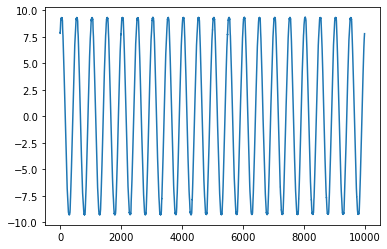

In [7]:
plt.plot(Data['769']['current'])

In [62]:
fs = 30000
f0 = 60
NS = fs//f0 # number of samples per period
NP = npts//NS # number of periods for npts

# calculate the representative one period of steady state 
# (mean of the aggregated signals over one cycle)
n = len(Data)
rep_I = np.empty([n,NS])
rep_V = np.empty([n,NS])
for i in range(n):
    tempI = np.sum(np.reshape(Data[str(i+1)]['current'],[NP,NS]),0)/NP
    tempV = np.sum(np.reshape(Data[str(i+1)]['voltage'],[NP,NS]),0)/NP
    # align current to make all samples start from 0 and goes up
    ix = np.argsort(np.abs(tempI))
    j = 0
    while True:
        if ix[j]<499 and tempI[ix[j]+1]>tempI[ix[j]]:
            real_ix = ix[j]
            break
        else:
            j += 1
    rep_I[i,] = np.hstack([tempI[real_ix:],tempI[:real_ix]])
    rep_V[i,] = np.hstack([tempV[real_ix:],tempV[:real_ix]])

# CWT

In [63]:
import pywt

In [64]:
def make_recurcisve_wavelet_plot(data, waveletname, iters):
    fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    for ii in range(iters):
        (data, coeff_d) = pywt.dwt(data, waveletname)
        if ii == iters - 1:
            axarr[0].plot(data, 'r')
            axarr[1].plot(coeff_d, 'g')
            axarr[0].set_ylabel("{}".format(ii + 1), fontsize=14, rotation=90)
            axarr[0].set_yticklabels([])
            axarr[1].set_yticklabels([])
    plt.tight_layout()
    plt.show()

In [65]:
def make_recurcisve_wavelet_transform(data, waveletname, iters):
    for ii in range(iters):
        (data, coeff_d) = pywt.dwt(data, waveletname)
        if ii == iters - 1:
            return data, coeff_d

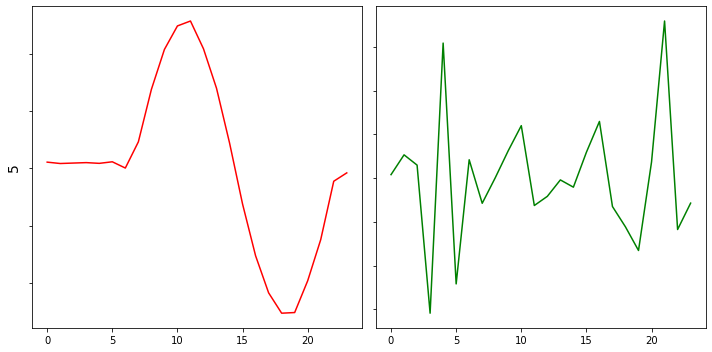

In [71]:
make_recurcisve_wavelet_plot(rep_I[1769], 'db5', 5)

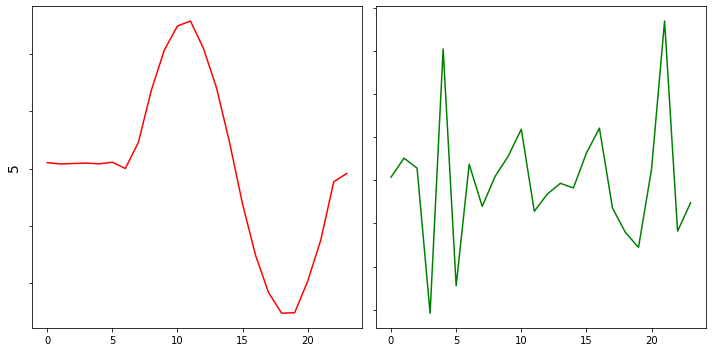

In [70]:
make_recurcisve_wavelet_plot(rep_I[1770], 'db5', 5)

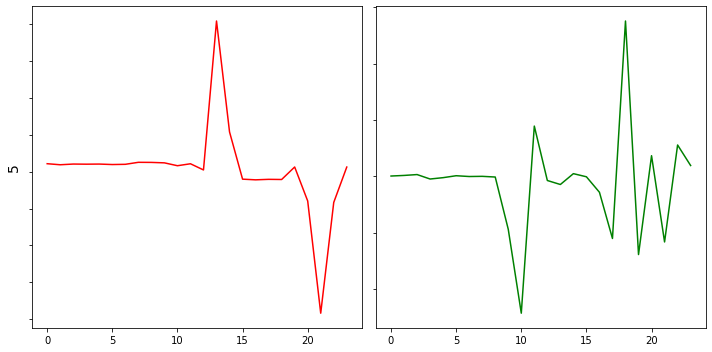

In [69]:
make_recurcisve_wavelet_plot(rep_I[1000], 'db5', 5)

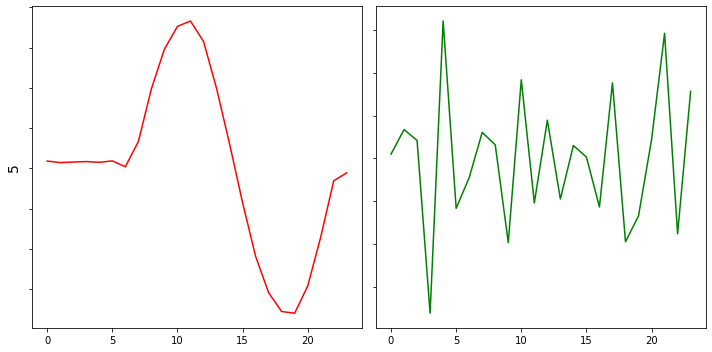

In [72]:
make_recurcisve_wavelet_plot(rep_I[235], 'db5', 5)

In [15]:
def center(X,w):
    minX = np.amin(X)
    maxX = np.amax(X)
    dist = max(abs(minX),maxX)
    X[X<-dist] = -dist
    X[X>dist] = dist
    d = (maxX-minX)/w
    return (X,d)
    
def get_img_from_coef(coefs, steps, width,hard_threshold=False,para=.5):
    d = coefs.shape[0]
    # doing interploation if number of points is less than width*2
    if d < 2 * width:
        newsteps = np.hstack([coefs, coefs[0]])
        newcoefs = np.hstack([steps, steps[0]])
        oldt = np.linspace(0, d, d + 1)
        newt = np.linspace(0, d, 2*width)
        steps = np.interp(newt, oldt, newsteps)
        coefs = np.interp(newt, oldt, newcoefs)
    # center the current and coefsoltage, get the size resolution of mesh gicoefsen width    
    (steps, d_c)  = center(steps, width)
    (coefs, d_coefs)  = center(coefs, width)
    
    #  find the index where the coefssteps goes through in current-coefsoltage axis
    ind_c = np.floor((steps - np.amin(steps)) / d_c).astype(int)
    ind_coefs = np.floor((coefs - np.amin(coefs)) / d_coefs).astype(int)
    ind_c[ind_c==width] = width - 1
    ind_coefs[ind_coefs==width] = width - 1
    
    stepsmg = np.zeros((width,width))
    
    for i in range(len(steps)):
        stepsmg[ind_c[i],width-ind_coefs[i]-1] += 1
    
    if hard_threshold:
        stepsmg[stepsmg<para] = 0
        stepsmg[stepsmg!=0] = 1
        return stepsmg
    else:
        return (stepsmg/np.max(stepsmg))**para

In [137]:
n = len(Data)
width = 16

Imgs = np.zeros((n,width,width), dtype=np.float64)
for i in range(n):
    data_I, coef_I = make_recurcisve_wavelet_transform(rep_I[i], 'db5', 6)
    Imgs[i,:,:] = get_img_from_coef(coef_I, np.linspace(0, len(coef_I), len(coef_I)), width,True,1)
BinaryF=np.reshape(Imgs, (n, width * width))

In [138]:
type_Ids = {}
loc_Ids = {}
n = len(Data)
type_label = np.zeros(n,dtype='int')
loc_label = np.zeros(n,dtype='int')
for (ii,t) in enumerate(Unq_type):
    type_Ids[t] = [i-1 for i,j in enumerate(Types,start=1) if j == t]
    type_label[type_Ids[t]] = ii+1
for (ii,t) in enumerate(Unq_loc):
    loc_Ids[t] = [i-1 for i,j in enumerate(Locs,start=1) if j == t]
    loc_label[loc_Ids[t]] = ii+1
print('number of different types: %d'% len(Unq_type))
print('number of different households: %d'% len(Unq_loc))

number of different types: 16
number of different households: 65


<ipython-input-139-9f146c8c15b2>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(np.ceil(n / 10), 15, count)


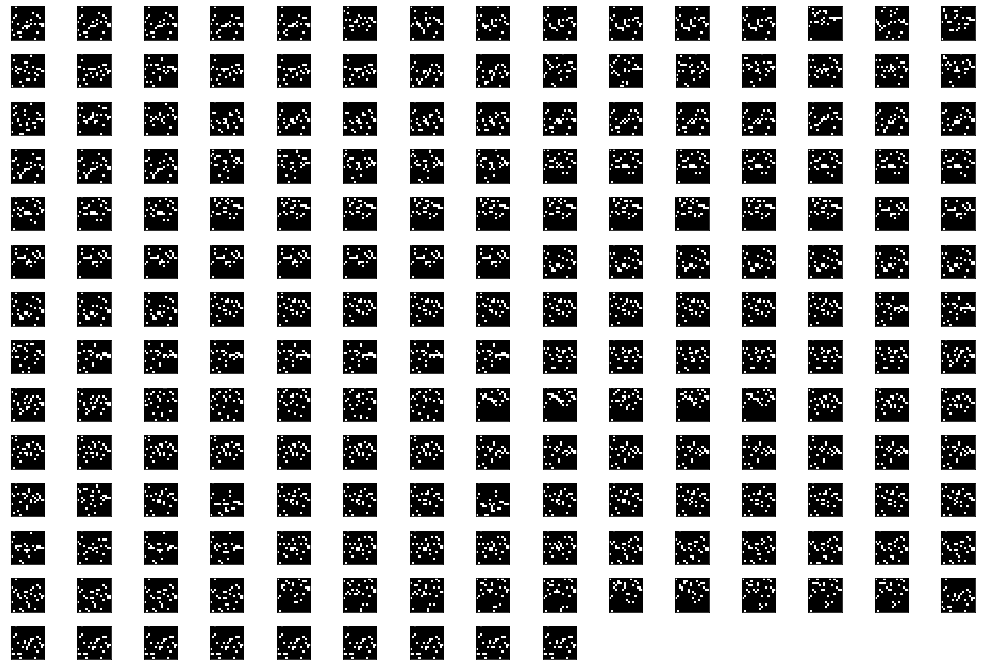

In [139]:
# visualization of all imgaes from certain type in Imgs
type_id = 1
n = sum(type_label==type_id)
fig = plt.figure(figsize=(14,np.ceil(n/15)))
count = 1
for i in np.where(type_label==type_id)[0]:
    plt.subplot(np.ceil(n / 10), 15, count)
    plt.imshow(Imgs[i,:,:],cmap = cm.Greys_r,interpolation='None')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    count += 1
fig.tight_layout()
plt.show()

# CNN

In [140]:
from sklearn.model_selection import train_test_split


X_train_cwt, X_test_cwt, y_train_cwt, y_test_cwt = train_test_split(BinaryF, type_label, test_size=0.1, random_state=42)

In [141]:
from collections import defaultdict, Counter
import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.models import Sequential
from keras.layers import Dropout

from keras.callbacks import History 

history_cwt = History()
img_x_cwt = 16
img_y_cwt = 16
img_z_cwt = 1

num_classes = 17

x_train_cwt = X_train_cwt.reshape(X_train_cwt.shape[0], img_x_cwt, img_y_cwt, img_z_cwt)
x_test_cwt = X_test_cwt.reshape(X_test_cwt.shape[0], img_x_cwt, img_y_cwt, img_z_cwt)
y_train_cwt = keras.utils.to_categorical(y_train_cwt, num_classes)
y_test_cwt = keras.utils.to_categorical(y_test_cwt, num_classes)

In [142]:
input_sh_cwt = (img_x_cwt, img_y_cwt, img_z_cwt)
epochs = 50
batch_size = 200

model_cwt = Sequential()
model_cwt.add(Conv2D(32, kernel_size=(2, 2), strides=(1, 1), input_shape=input_sh_cwt))
model_cwt.add(AveragePooling2D(pool_size=(3, 3), strides=(1, 1)))
model_cwt.add(Conv2D(64, kernel_size=(2, 2), strides=(1, 1)))
model_cwt.add(AveragePooling2D(pool_size=(2, 2)))
model_cwt.add(Flatten())
model_cwt.add(Dense(1000, activation='relu'))
model_cwt.add(Dropout(0.2, input_shape=(1,)))
model_cwt.add(Dense(num_classes, activation='softmax'))
                     
model_cwt.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(), 
              metrics=['accuracy'])

model_cwt.fit(x_train_cwt, y_train_cwt, batch_size=batch_size, 
          epochs=epochs, verbose=1, 
          validation_data=(x_test_cwt, y_test_cwt), 
          callbacks=[history_cwt])

train_score = model_cwt.evaluate(x_train_cwt, y_train_cwt, verbose=0)
print('Train loss: {}, Train accuracy: {}'.format(train_score[0], train_score[1]))
test_score = model_cwt.evaluate(x_test_cwt, y_test_cwt, verbose=0)
print('Test loss: {}, Test accuracy: {}'.format(test_score[0], test_score[1]))

Epoch 1/50
9/9 [==============================] - 1s 61ms/step - loss: 2.5224 - accuracy: 0.2167 - val_loss: 1.9953 - val_accuracy: 0.4681
Epoch 2/50
9/9 [==============================] - 0s 49ms/step - loss: 1.8208 - accuracy: 0.4294 - val_loss: 1.5219 - val_accuracy: 0.5160
Epoch 3/50
9/9 [==============================] - 0s 49ms/step - loss: 1.5364 - accuracy: 0.5048 - val_loss: 1.2692 - val_accuracy: 0.6011
Epoch 4/50
9/9 [==============================] - 0s 49ms/step - loss: 1.3430 - accuracy: 0.5563 - val_loss: 1.1840 - val_accuracy: 0.6064
Epoch 5/50
9/9 [==============================] - 0s 49ms/step - loss: 1.1606 - accuracy: 0.6199 - val_loss: 1.0547 - val_accuracy: 0.6649
Epoch 6/50
9/9 [==============================] - 1s 59ms/step - loss: 1.0405 - accuracy: 0.6545 - val_loss: 0.9858 - val_accuracy: 0.6862
Epoch 7/50
9/9 [==============================] - 0s 51ms/step - loss: 0.9540 - accuracy: 0.6812 - val_loss: 0.8985 - val_accuracy: 0.7021
Epoch 8/50
9/9 [===========

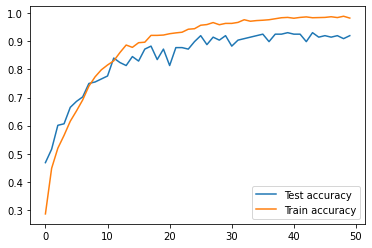

In [143]:
plt.plot(history_cwt.epoch, np.array(history_cwt.history['val_accuracy']),
           label = 'Test accuracy')
plt.plot(history_cwt.epoch, np.array(history_cwt.history['accuracy']),
           label = 'Train accuracy')
plt.legend()
plt.show()

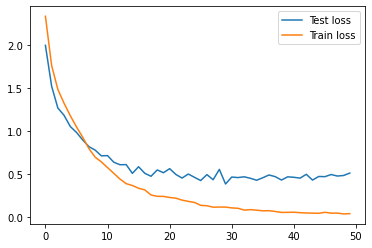

In [144]:
plt.plot(history_cwt.epoch, np.array(history_cwt.history['val_loss']),
           label = 'Test loss')
plt.plot(history_cwt.epoch, np.array(history_cwt.history['loss']),
           label = 'Train loss')
plt.legend()
plt.show()